In [11]:
import os
import pandas as pd
import cv2
from tqdm import tqdm
import numpy as np
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split


# keras import
from keras.applications import VGG16, ResNet50, Xception
from keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input

In [12]:
disease_types = ['COVID', 'non-COVID']
data_dir = "C:\\Users\\Asus\\OneDrive - Amrita Vishwa Vidyapeetham\\SEM 5\\21AIE303 Signal and Image Processing\\Research Paper\\CT_COVID"

In [13]:
train_dir = os.path.join(data_dir)
train_data = []

for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])

train = pd.DataFrame(train_data, columns=['File', 'DiseaseID', 'Disease Type'])

train

,File,DiseaseID,Disease Type
0,COVID/Covid (1).png,0,COVID
1,COVID/Covid (10).png,0,COVID
2,COVID/Covid (100).png,0,COVID
3,COVID/Covid (1000).png,0,COVID
4,COVID/Covid (1001).png,0,COVID
...,...,...,...
2476,non-COVID/Non-Covid (995).png,1,non-COVID
2477,non-COVID/Non-Covid (996).png,1,non-COVID
2478,non-COVID/Non-Covid (997).png,1,non-COVID
2479,non-COVID/Non-Covid (998).png,1,non-COVID


In [20]:
IMAGE_SIZE = 64

def read_image(filepath):
	return cv2.imread(os.path.join(data_dir, filepath))

def resize_image(image, image_size):
	return cv2.resize(image.copy(), image_size,
					interpolation=cv2.INTER_AREA)

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

# tqdm displays current iterations and time took for completion of loop
for i, file in tqdm(enumerate(train['File'].values)):
	image = read_image(file)
	if image is not None:
		X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

# contains all the covid and non-covid CT-scans
X_Train = X_train / 255.

Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

2481it [00:08, 287.82it/s]


In [21]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state = 42)

In [22]:
BATCH_SIZE = 64
EPOCHS = 100
SIZE=64
N_ch=3

In [23]:
def build_Xception():
    xception = Xception(weights='imagenet', include_top=False)

    input = Input(shape=(SIZE, SIZE, N_ch))
    x = Conv2D(3, (3, 3), padding='same')(input)
    
    x = xception(x)
    
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)

    # multi output
    output = Dense(2,activation = 'softmax', name='root')(x)
 

    # model
    model = Model(input,output)
    
    optimizer = Adam(lr=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    
    return model

In [24]:
model = build_Xception()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('Xception_Model.hdf5', verbose=1, save_best_only=True)
datagen = ImageDataGenerator(rotation_range=360, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2,
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True) 

datagen.fit(X_train)

83683744/83683744 [==============================] - 103s 1us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 3)         84        
                                                                 
 xception (Functional)       (None, None, None, 2048)  20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_8 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                          

In [25]:
history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=1,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

Epoch 1/100


C:\Users\Asus\AppData\Local\Temp\ipykernel_14432\391079107.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),


31/31 [==============================] - ETA: 0s - loss: 1.1953 - accuracy: 0.4929
Epoch 1: val_loss improved from inf to 0.73081, saving model to Xception_Model.hdf5
31/31 [==============================] - 114s 3s/step - loss: 1.1953 - accuracy: 0.4929 - val_loss: 0.7308 - val_accuracy: 0.4809 - lr: 0.0030
Epoch 2/100
31/31 [==============================] - ETA: 0s - loss: 1.0959 - accuracy: 0.5318
Epoch 2: val_loss did not improve from 0.73081
31/31 [==============================] - 110s 4s/step - loss: 1.0959 - accuracy: 0.5318 - val_loss: 0.7848 - val_accuracy: 0.4809 - lr: 0.0030
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.9625 - accuracy: 0.5585
Epoch 3: val_loss did not improve from 0.73081
31/31 [==============================] - 113s 4s/step - loss: 0.9625 - accuracy: 0.5585 - val_loss: 0.7820 - val_accuracy: 0.4809 - lr: 0.0030
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.8929 - accuracy: 0.5635
Epoch 4: val_loss improve

Epoch 27/100
31/31 [==============================] - ETA: 0s - loss: 0.3372 - accuracy: 0.8654
Epoch 27: val_loss improved from 0.32490 to 0.31563, saving model to Xception_Model.hdf5
31/31 [==============================] - 111s 4s/step - loss: 0.3372 - accuracy: 0.8654 - val_loss: 0.3156 - val_accuracy: 0.8632 - lr: 0.0030
Epoch 28/100
31/31 [==============================] - ETA: 0s - loss: 0.3307 - accuracy: 0.8715
Epoch 28: val_loss improved from 0.31563 to 0.31282, saving model to Xception_Model.hdf5
31/31 [==============================] - 111s 4s/step - loss: 0.3307 - accuracy: 0.8715 - val_loss: 0.3128 - val_accuracy: 0.8692 - lr: 0.0030
Epoch 29/100
31/31 [==============================] - ETA: 0s - loss: 0.3277 - accuracy: 0.8690
Epoch 29: val_loss did not improve from 0.31282
31/31 [==============================] - 111s 4s/step - loss: 0.3277 - accuracy: 0.8690 - val_loss: 0.3333 - val_accuracy: 0.8551 - lr: 0.0030
Epoch 30/100
31/31 [==============================] - ETA

Epoch 54/100
31/31 [==============================] - ETA: 0s - loss: 0.2582 - accuracy: 0.9052
Epoch 54: val_loss did not improve from 0.27919
31/31 [==============================] - 116s 4s/step - loss: 0.2582 - accuracy: 0.9052 - val_loss: 0.2829 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 55/100
31/31 [==============================] - ETA: 0s - loss: 0.2941 - accuracy: 0.8856
Epoch 55: val_loss did not improve from 0.27919
31/31 [==============================] - 120s 4s/step - loss: 0.2941 - accuracy: 0.8856 - val_loss: 0.2912 - val_accuracy: 0.8853 - lr: 0.0010
Epoch 56/100
31/31 [==============================] - ETA: 0s - loss: 0.2792 - accuracy: 0.8972
Epoch 56: val_loss did not improve from 0.27919
31/31 [==============================] - 122s 4s/step - loss: 0.2792 - accuracy: 0.8972 - val_loss: 0.2977 - val_accuracy: 0.8773 - lr: 0.0010
Epoch 57/100
31/31 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.8936
Epoch 57: val_loss did not improve from 0.2

Epoch 81/100
31/31 [==============================] - ETA: 0s - loss: 0.2591 - accuracy: 0.9012
Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002470628678565845.

Epoch 81: val_loss did not improve from 0.27127
31/31 [==============================] - 123s 4s/step - loss: 0.2591 - accuracy: 0.9012 - val_loss: 0.2836 - val_accuracy: 0.8853 - lr: 3.5295e-04
Epoch 82/100
31/31 [==============================] - ETA: 0s - loss: 0.2577 - accuracy: 0.9057
Epoch 82: val_loss did not improve from 0.27127
31/31 [==============================] - 120s 4s/step - loss: 0.2577 - accuracy: 0.9057 - val_loss: 0.2834 - val_accuracy: 0.8913 - lr: 2.4706e-04
Epoch 83/100
31/31 [==============================] - ETA: 0s - loss: 0.2458 - accuracy: 0.9052
Epoch 83: val_loss did not improve from 0.27127
31/31 [==============================] - 119s 4s/step - loss: 0.2458 - accuracy: 0.9052 - val_loss: 0.2810 - val_accuracy: 0.8913 - lr: 2.4706e-04
Epoch 84/100
31/31 [=============================

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

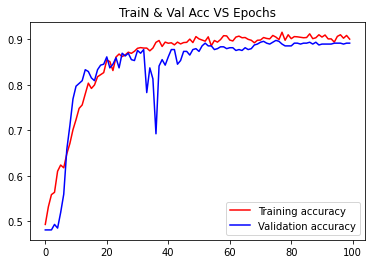

<Figure size 432x288 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

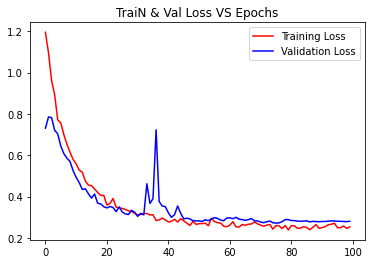

<Figure size 432x288 with 0 Axes>

In [29]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [30]:
model.load_weights("Xception_Model.hdf5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

16/16 [==============================] - 4s 240ms/step - loss: 0.2713 - accuracy: 0.8974
Test Loss: 0.27126866579055786
Test accuracy: 89.73842859268188


16/16 [==============================] - 4s 243ms/step


Text(0.5, 1.0, 'Confusion Matrix')

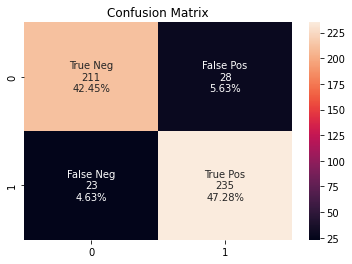

In [33]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")